# Setup (can be largely ignored)

In [124]:
accuracy_dict = {}

In [125]:
# Imports 


import sys
# setting path
sys.path.append('../core')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"


from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

# import dfply
# from dfply import *
# import ray
# import datetime


import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

In [413]:
current_horizon = 70

In [414]:
# Generate a single environment


envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]


horizon = current_horizon #18

#, slip = 0.04, confound_weight=0.6
# IMPORTANT
# When testing with model difference, make sure pi_b's are the same between models
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                    confound_weight=0.1, small=False, soft=True)


# R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

# Generate evaluation policy
pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]

    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])


In [415]:
# Multiprocessing adjusted for Windows


def getSamplesMultiProc(samples, mdp, pi_b, horizon, iid=True):
    nprocs = multiprocessing.cpu_count()
    with ProcessPoolExecutor(max_workers=nprocs, mp_context=multiprocessing.get_context('spawn')) as executor:
        future = executor.map(collect_sample, [int(samples/nprocs) for i in range(nprocs)], repeat(copy.deepcopy(mdp)), 
                              repeat(copy.deepcopy(pi_b)), repeat(horizon), [i for i in range(nprocs)], repeat(iid))
    dataset = np.vstack(list(future))
    return dataset

In [416]:
# Test behavior policy and obtain its value, generates Phat and pihat


for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in [envs[-1]]:
    
    print("---")
    
    print("running env with horizon", horizon)

    #dataset = confound_mdp.collect_sample(int(100), mdp, pi_b, horizon, iid=False)
    #pi_b = np.array([pi_b.mean(0),pi_b.mean(0)])
    
    # shape num_traj, horizon, 5 - 5 means (s,a,u,s',r)
    dataset = getSamplesMultiProc(1000, mdp, pi_b, horizon, iid=False)
    # IMPORTANT iid=False enforces the global assumption
    
    # shape num_traj*horizon, 5 
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    
    # Estimate transition probability
    Phat = confound_ope.estimate_P(dataset, mdp)
    
    # Estimate policy
    pihat = confound_ope.estimate_pi(dataset, mdp)
    
    # Make both 
    for a in range(nActions):
        for s in range(nStates):
            if Phat[a,s].sum() == 0:
                Phat[a,s,term] = 1
            if pihat[s].sum() == 0:
                pihat[s,:] = 1/nActions
                
                
    pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]

    # This is the actual reward_sa
    # P(s,a,s') * R(s,a,s')
    # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
    R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
    P_spsa = Phat.transpose((2, 1, 0))
    n = data.shape[0]


     # behavior value
    print("value of pi_b")
    returns = confound_mdp.calc_returns(dataset, gamma, horizon)
    print(returns.mean())

---
running env with horizon 70
value of pi_b
-3.397332415727575


In [417]:
# Computes the policy, Pb, and (s,a) counts


from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)

# shape S, A
pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)

# shape S (s'), S (s), A (a)
Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)

# s,a counts for each pair - shape S, A
N_sa = getN_sa(dataset, nStates, nActions)

# Subspace Estimation

In [418]:
# From all trajectories, extracts arrays giving states, actions, (s,a) pairs, confounder labels and next states
# Sets up 2 other variables - stateactions and K, the total number of confounders


# s,a arranged in the standard C format
memorder = 'C'

# stateactions numbers the (s,a) pair recorded in the data using either the 
# C or FORTRAN numbering format for flattening 2D arrays
# Shape num_traj, horizon_length
if memorder == 'F': # s,a arranged in the Fortran format (deprecated)
    stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
else:
    stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
    
# Extract arrays
# Shape num_traj, horizon length (except for 'labels')
states = (dataset[:,:,0]).astype(int)
actions = (dataset[:,:,1]).astype(int)
currstates = dataset[:,:,[0,1]].astype(int)
nextstates = dataset[:,:,3].astype(int)
confounders = dataset[:,:,2].astype(int)

#shape num_traj
labels = confounders[:,0].astype(int)

# Total number of confounders
K = 2

In [419]:
# Gets one hot representations of the trajectory data


sadim = nStates*nActions # SA
spdim = nStates # S

# Determine the omega1 and omega2 segments
omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])

# Get one hot vectors for each (s,a) pair recorded 
# Shape num_traj, horizon_length, SA
onehotsa = np.eye(int(np.max(stateactions))+1)[stateactions]

# Get a deep copy of onehotsa
onehotsaflat = copy.deepcopy(onehotsa)

# Reshape onehotsa by splitting the SA one hot vector into an S,A array
onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)

# Returns one hot vectors for each s' state recorded
onehotsp = np.eye(np.max(nextstates)+1)[nextstates]

# Index at which to split the dataset (1/3 for subspace estimation and 2/3 for clustering)
sz = int(onehotsa.shape[0]/3)

In [420]:
# Splits the data (in its one hot representation) into data for subspace estimation and clustering


onehotsasub = onehotsa[:sz]
onehotsaflatsub = onehotsaflat[:sz]
onehotspsub = onehotsp[:sz]

onehotsaclust = onehotsa[sz:]
onehotsaflatclust = onehotsaflat[sz:]
onehotspclust = onehotsp[sz:]

In [421]:
# Executes the biggest part of the subspace estimation algorithm
# Gets the top K eigenvalues and corresponding eigenvectors of the matrix H+H^T


eigvalsa, eigvecsa = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, K, wt=True)

(array([62.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-46.05170186, -45.46077512, -44.86984838, -44.27892164,
        -43.6879949 , -43.09706816, -42.50614142, -41.91521468,
        -41.32428794, -40.7333612 , -40.14243446, -39.55150773,
        -38.96058099, -38.36965425, -37.77872751, -37.18780077,
        -36.59687403, -36.00594729, -35.41502055, -34.82409381,
        -34.23316707, -33.64224033, -33.05131359, -32.46038685,
        -31.86946011, -31.27853337, -30.68760663, -30.09667989,
        -29.50575315, -28.91482641, -28.32389967, -27.73297294,
        -27.1420462 , -26.55111946, -25.96019272, -25.36926598,
        -24.77833924, -24.1874125 , -23.59648576, -23.00555902

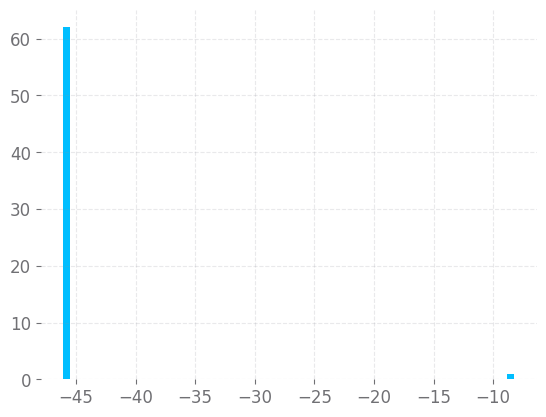

In [422]:
# Sanity check - plots logs of ALL eigenvalues of the matrix H+H^T


vals, vecs = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, 10000, wt=True)

plt.hist(np.log(vals[1,0]+1e-20), bins=64) #(s,a,eigs)

# Clustering

In [423]:
%load_ext autoreload
%autoreload 2
from clustering import *
import clustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [424]:
# Evaluate the distance values dist_(m,n) between all pairs (m,n) of trajectories
# Called statmns for now


# Set the device to the GPU
device = "/GPU:0"

# Get a transition structure estimate from each trajectory
hs = np.array([geth(onehotsaclust[:,omegaone,:,:], 
                                     onehotspclust[:,omegaone,:]), 
                              geth(onehotsaclust[:,omegatwo,:,:], 
                                   onehotspclust[:,omegatwo,:])])

# Use it to get the num_traj, num_traj matrix of similarity or distance values between pairs of trajectories.
# NOTE 1: delete device=device if you aren't using your GPU
# NOTE 2: set smalldata=True if you don't want too munch load on your memory
statmns = computeStat(hs, 
                      eigvecsa, numpy=False, smalldata=False, device=device, proj=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.74it/s]


<BarContainer object of 1000 artists>

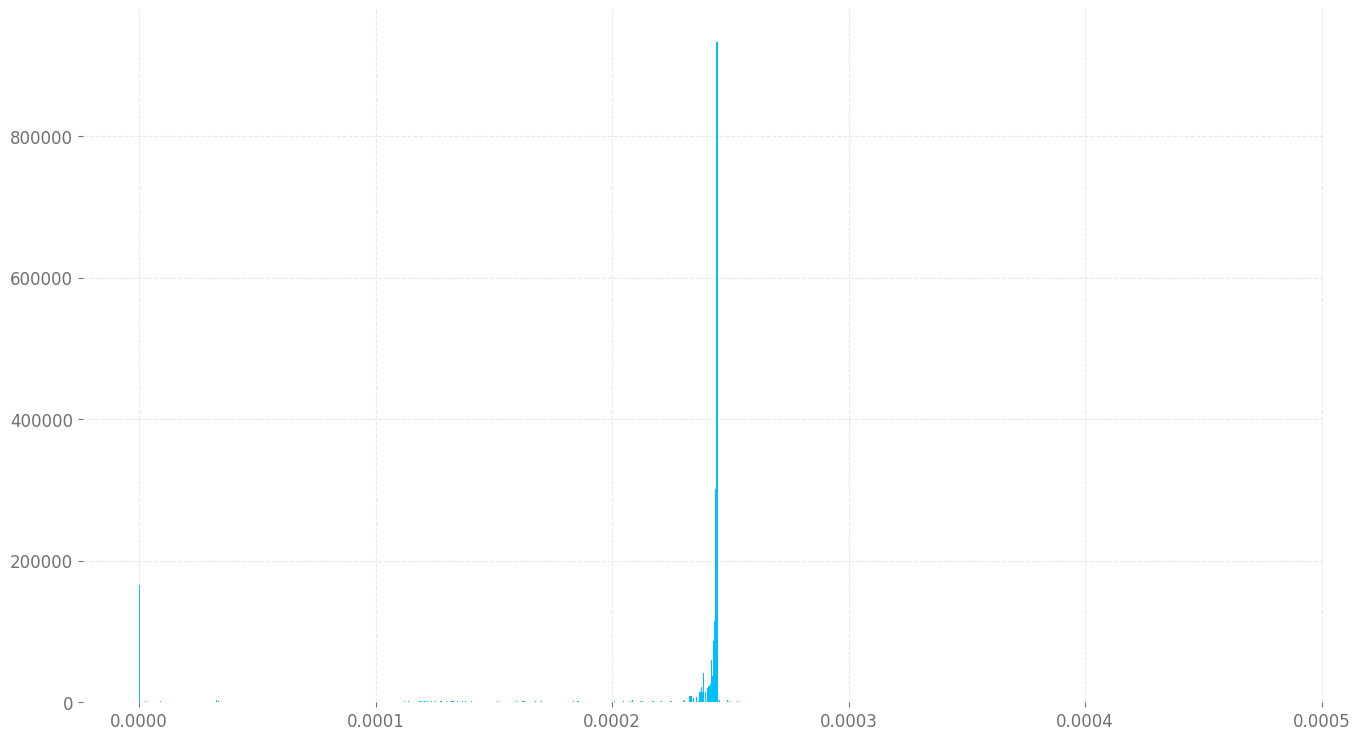

In [425]:
# Plot a histogram of the estimated distance values to determine the threshold


plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=1000, density=True, cumulative=False)[2]

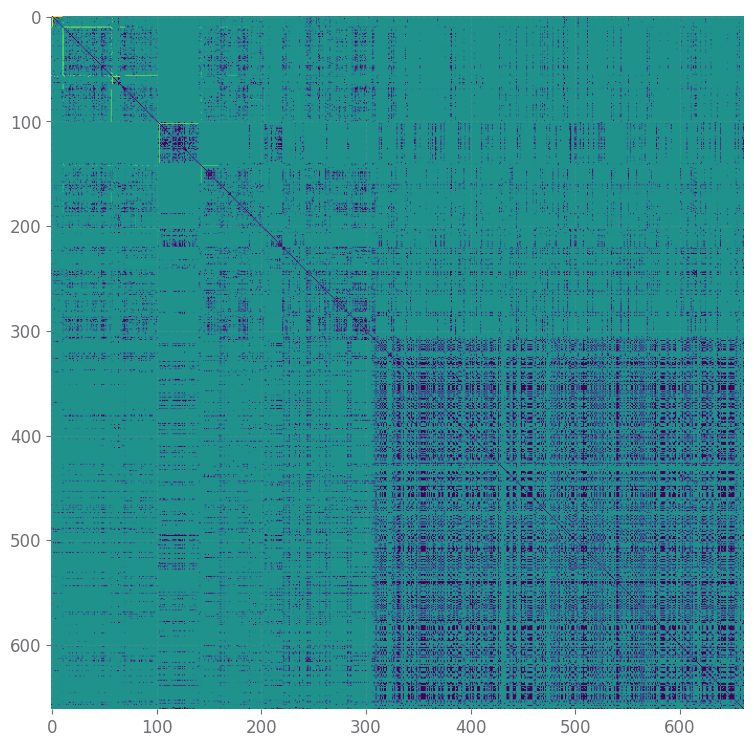

In [426]:
# Get a block matrix visualization for the distance values


from scipy.cluster.hierarchy import linkage

m = 1-statmns #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

plt.figure(figsize=(16,9))
plt.imshow(1-m)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.66it/s]


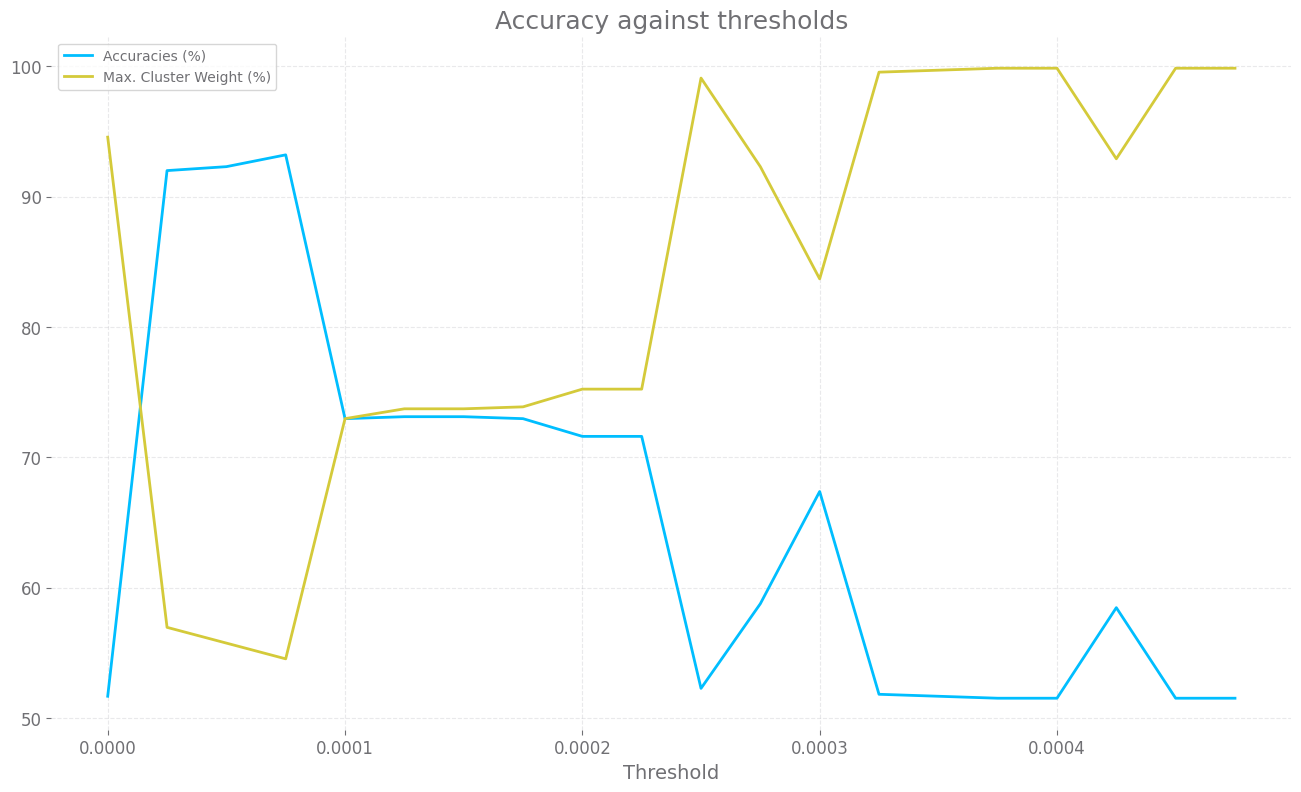

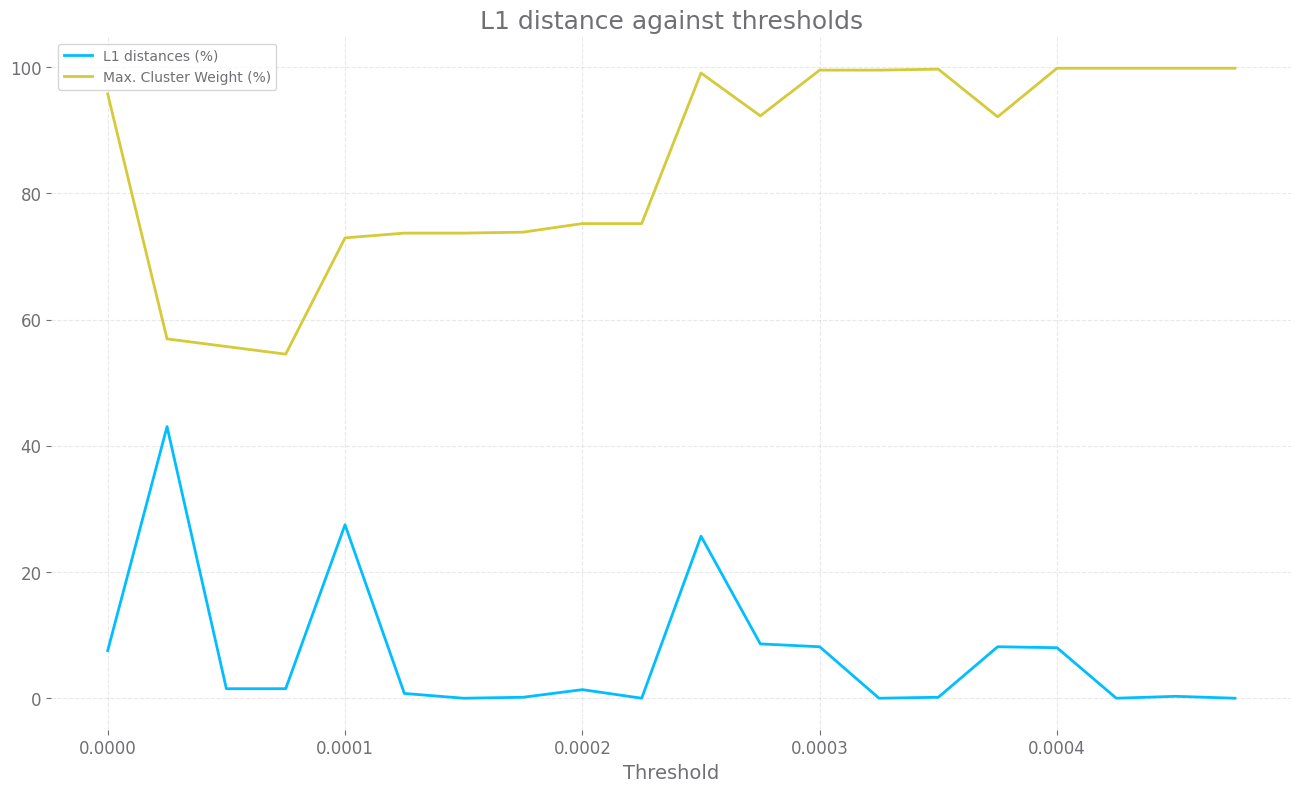

In [427]:
# Vary thresholds and understand how the predicted labels change
# We use the true labels the first time, but not the second time


# Plot the accuracies against the predicted labels for various values of thresholds 
# Range thresholds between lo and hi with step 'step'
clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                   lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001

# Plot the L1 distance between the predicted label distributions for consecutive values of 
# Range thresholds between lo and hi with step 'step'
clusterDiagnosticsHiddenTruth(statmns, K=K,
                   lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001

In [428]:
# Initialize a tsne visualization for the cluster labels


tsne = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, 
                             metric='precomputed').fit_transform(statmns) #1-(statmns2 < 0.002)

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

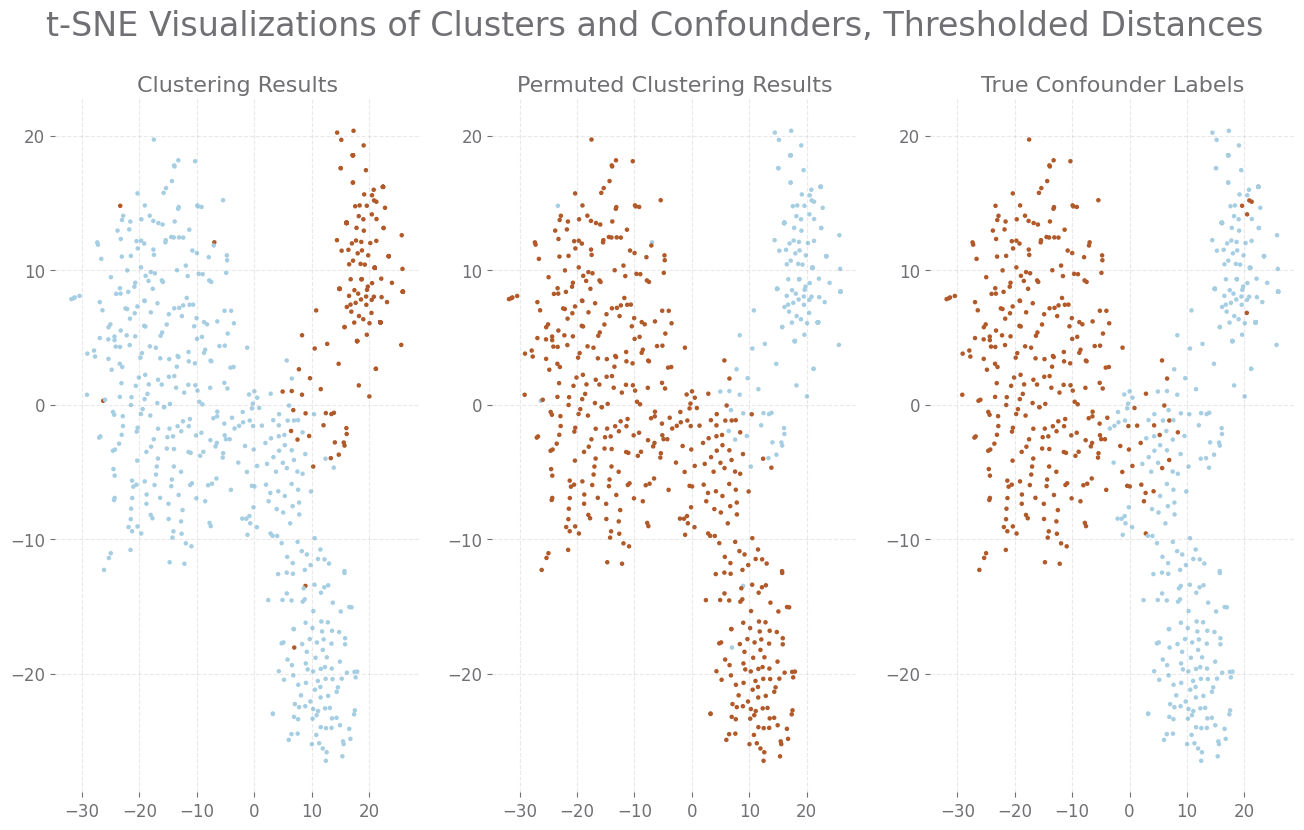

In [429]:
# Plot the tsne visualization


clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.0001).astype(int), n_clusters=K,
                                                     assign_labels='kmeans')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

In [430]:
# Permutes the cluster labels to match the true labels
# This is needed since clustering only makes clusters of datapoints 
# and doesn't guarantee that the cluster labels match the original hidden labels


permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])])
accuracy = np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])])
print(permutation, accuracy)
accuracy_dict[current_horizon] = accuracy

1 0.729607250755287


In [431]:
accuracy_dict = {i: accuracy_dict[i] for i in sorted(accuracy_dict.keys())}

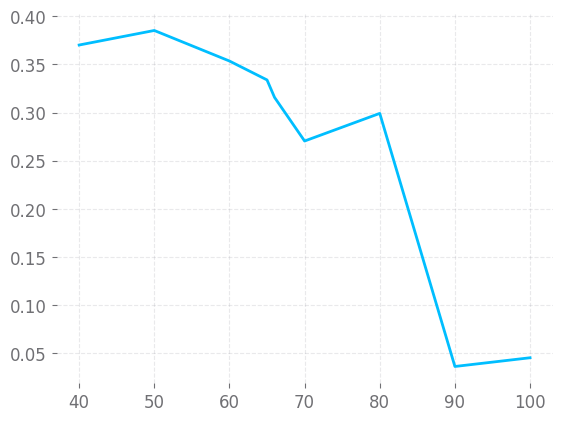

In [432]:
plt.plot(accuracy_dict.keys(), 1-np.array(list(accuracy_dict.values())))

# Model Estimation

In [116]:
# Estimates the model and stores it in an array of shape K, S, A, S'


Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                         states[sz:,:], 
                         actions[sz:,:], 
                         nextstates[sz:,:],
                        K=K, nStates=nStates, nActions=nActions, hard=True)

# Classification

In [81]:
# 